In [1]:
!pip -q install -U scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_recall_fscore_support

CSV_PATH = "manipal_atmospherics_df.csv"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 56.6 MB/s eta 0:00:00


In [2]:
TEMP_COL = "temperature_2m_mean (°C)"
PRECIP_COL = "precipitation_sum (mm)"
DEW_COL = "dew_point_2m_mean (°C)"
PRESSURE_COL = "pressure_msl_mean (hPa)"
WIND_COL = "wind_speed_10m_max (km/h)"


def load_weather_df(csv_path: str) -> pd.DataFrame:
    with open(csv_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    header_idx = None
    for i, line in enumerate(lines):
        if line.strip().startswith("time,"):
            header_idx = i
            break

    if header_idx is None:
        raise ValueError("Header row starting with 'time,' not found.")

    df = pd.read_csv(csv_path, skiprows=header_idx)
    df["time"] = pd.to_datetime(df["time"])
    df = df.drop_duplicates(subset="time").sort_values("time").reset_index(drop=True)

    t = df[TEMP_COL]
    td = df[DEW_COL]
    es = 6.112 * np.exp((17.67 * t) / (t + 243.5))
    e = 6.112 * np.exp((17.67 * td) / (td + 243.5))
    df["relative_humidity (%)"] = (100.0 * (e / es)).clip(0, 100)

    day = df["time"].dt.dayofyear
    df["sin_day_of_year"] = np.sin(2 * np.pi * day / 365.25)
    df["cos_day_of_year"] = np.cos(2 * np.pi * day / 365.25)

    return df


df = load_weather_df(CSV_PATH)

required_cols = [
    "time",
    TEMP_COL,
    PRECIP_COL,
    DEW_COL,
    PRESSURE_COL,
    WIND_COL,
    "relative_humidity (%)",
    "sin_day_of_year",
    "cos_day_of_year",
]

model_df = df[required_cols].dropna().reset_index(drop=True)
model_df.head()

,time,temperature_2m_mean (°C),precipitation_sum (mm),dew_point_2m_mean (°C),pressure_msl_mean (hPa),wind_speed_10m_max (km/h),relative_humidity (%),sin_day_of_year,cos_day_of_year
0,2011-01-04,24.7,0.0,20.4,1009.7,17.4,76.997277,0.068755,0.997634
1,2011-01-05,25.4,0.0,20.4,1008.7,15.9,73.847916,0.085906,0.996303
2,2011-01-06,26.2,0.0,19.4,1008.7,18.4,66.189954,0.103031,0.994678
3,2011-01-07,25.6,0.0,18.6,1008.6,15.6,65.244754,0.120126,0.992759
4,2011-01-08,25.2,0.0,20.0,1008.3,15.1,72.905760,0.137185,0.990545


In [3]:
LOOKBACK = 30
BATCH_SIZE = 32
MAX_EPOCHS = 50
PATIENCE = 7


def split_by_time(df: pd.DataFrame, train_ratio=0.7, val_ratio=0.15):
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    return df.iloc[:train_end], df.iloc[train_end:val_end], df.iloc[val_end:]


def make_windows(X, y, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i - lookback : i])
        ys.append(y[i])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)


def make_windows_precip(X, y_rain, y_amount, lookback):
    Xs, rain, amount = [], [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i - lookback : i])
        rain.append(y_rain[i])
        amount.append(y_amount[i])
    return (
        np.array(Xs, dtype=np.float32),
        np.array(rain, dtype=np.float32),
        np.array(amount, dtype=np.float32),
    )


def prepare_data(df_train, df_val, df_test, feature_cols, target_col, lookback, log_target=False):
    y_train = df_train[target_col].to_numpy(dtype=np.float32)
    y_val = df_val[target_col].to_numpy(dtype=np.float32)
    y_test = df_test[target_col].to_numpy(dtype=np.float32)

    if log_target:
        y_train = np.log1p(y_train)
        y_val = np.log1p(y_val)
        y_test = np.log1p(y_test)

    y_scaler = StandardScaler()
    y_train_s = y_scaler.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
    y_val_s = y_scaler.transform(y_val.reshape(-1, 1)).reshape(-1)
    y_test_s = y_scaler.transform(y_test.reshape(-1, 1)).reshape(-1)

    X_train = df_train[feature_cols].to_numpy(dtype=np.float32)
    X_val = df_val[feature_cols].to_numpy(dtype=np.float32)
    X_test = df_test[feature_cols].to_numpy(dtype=np.float32)

    x_scaler = StandardScaler()
    X_train_s = x_scaler.fit_transform(X_train)
    X_val_s = x_scaler.transform(X_val)
    X_test_s = x_scaler.transform(X_test)

    X_train_w, y_train_w = make_windows(X_train_s, y_train_s, lookback)
    X_val_w, y_val_w = make_windows(X_val_s, y_val_s, lookback)
    X_test_w, y_test_w = make_windows(X_test_s, y_test_s, lookback)

    return (X_train_w, y_train_w, X_val_w, y_val_w, X_test_w, y_test_w), x_scaler, y_scaler


def build_precip_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    rain = (df[PRECIP_COL] > 0).astype(np.float32)
    df["rain_yesterday"] = rain.shift(1).fillna(0.0)
    df["rain_days_last7"] = rain.shift(1).rolling(7).sum().fillna(0.0)
    df["precip_sum_last7"] = df[PRECIP_COL].shift(1).rolling(7).sum().fillna(0.0)
    return df


def prepare_precip_data(df_train, df_val, df_test, feature_cols, lookback):
    y_rain_train = (df_train[PRECIP_COL] > 0).astype(np.float32).to_numpy()
    y_rain_val = (df_val[PRECIP_COL] > 0).astype(np.float32).to_numpy()
    y_rain_test = (df_test[PRECIP_COL] > 0).astype(np.float32).to_numpy()

    y_amount_train = np.log1p(df_train[PRECIP_COL].to_numpy(dtype=np.float32))
    y_amount_val = np.log1p(df_val[PRECIP_COL].to_numpy(dtype=np.float32))
    y_amount_test = np.log1p(df_test[PRECIP_COL].to_numpy(dtype=np.float32))

    amount_scaler = StandardScaler()
    y_amount_train_s = amount_scaler.fit_transform(y_amount_train.reshape(-1, 1)).reshape(-1)
    y_amount_val_s = amount_scaler.transform(y_amount_val.reshape(-1, 1)).reshape(-1)
    y_amount_test_s = amount_scaler.transform(y_amount_test.reshape(-1, 1)).reshape(-1)

    X_train = df_train[feature_cols].to_numpy(dtype=np.float32)
    X_val = df_val[feature_cols].to_numpy(dtype=np.float32)
    X_test = df_test[feature_cols].to_numpy(dtype=np.float32)

    x_scaler = StandardScaler()
    X_train_s = x_scaler.fit_transform(X_train)
    X_val_s = x_scaler.transform(X_val)
    X_test_s = x_scaler.transform(X_test)

    X_train_w, rain_train_w, amount_train_w = make_windows_precip(
        X_train_s, y_rain_train, y_amount_train_s, lookback
    )
    X_val_w, rain_val_w, amount_val_w = make_windows_precip(
        X_val_s, y_rain_val, y_amount_val_s, lookback
    )
    X_test_w, rain_test_w, amount_test_w = make_windows_precip(
        X_test_s, y_rain_test, y_amount_test_s, lookback
    )

    return (
        X_train_w,
        rain_train_w,
        amount_train_w,
        X_val_w,
        rain_val_w,
        amount_val_w,
        X_test_w,
        rain_test_w,
        amount_test_w,
    ), x_scaler, amount_scaler


def persistence_baseline(target_series, lookback):
    y_true = target_series[lookback:]
    y_pred = target_series[lookback - 1 : -1]
    return y_true, y_pred

In [4]:
class GRUForecast(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=128,
            num_layers=2,
            dropout=0.3,
            batch_first=True,
        )
        self.head = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        _, h_n = self.gru(x)
        h_last = h_n[-1]
        out = self.head(h_last)
        return out.squeeze(-1)


def train_model(model, train_loader, val_loader):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    history = {"train": [], "val": []}
    best_val = float("inf")
    best_state = None
    wait = 0

    for _ in range(MAX_EPOCHS):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                pred = model(xb)
                loss = criterion(pred, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        history["train"].append(train_loss)
        history["val"].append(val_loss)

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= PATIENCE:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history


def predict(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(DEVICE)
            pred = model(xb).detach().cpu().numpy()
            preds.append(pred)
    return np.concatenate(preds)


def invert_target(y_scaled, y_scaler, log_target):
    y = y_scaler.inverse_transform(y_scaled.reshape(-1, 1)).reshape(-1)
    if log_target:
        y = np.expm1(y)
    return y


class GRUTwoHead(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=128,
            num_layers=2,
            dropout=0.3,
            batch_first=True,
        )
        self.rain_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
        self.amount_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        _, h_n = self.gru(x)
        h_last = h_n[-1]
        rain_logit = self.rain_head(h_last).squeeze(-1)
        amount_pred = self.amount_head(h_last).squeeze(-1)
        return rain_logit, amount_pred


def train_precip_model(model, train_loader, val_loader, lambda_amount=1.0):
    bce = nn.BCEWithLogitsLoss()
    mse = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    history = {"train": [], "val": []}
    best_val = float("inf")
    best_state = None
    wait = 0

    for _ in range(MAX_EPOCHS):
        model.train()
        train_loss = 0.0
        for xb, y_rain, y_amount in train_loader:
            xb = xb.to(DEVICE)
            y_rain = y_rain.to(DEVICE)
            y_amount = y_amount.to(DEVICE)

            optimizer.zero_grad()
            rain_logit, amount_pred = model(xb)

            loss_rain = bce(rain_logit, y_rain)
            rain_mask = y_rain > 0.5
            if rain_mask.any():
                loss_amount = mse(amount_pred[rain_mask], y_amount[rain_mask])
            else:
                loss_amount = torch.tensor(0.0, device=DEVICE)

            loss = loss_rain + lambda_amount * loss_amount
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item() * xb.size(0)

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, y_rain, y_amount in val_loader:
                xb = xb.to(DEVICE)
                y_rain = y_rain.to(DEVICE)
                y_amount = y_amount.to(DEVICE)
                rain_logit, amount_pred = model(xb)

                loss_rain = bce(rain_logit, y_rain)
                rain_mask = y_rain > 0.5
                if rain_mask.any():
                    loss_amount = mse(amount_pred[rain_mask], y_amount[rain_mask])
                else:
                    loss_amount = torch.tensor(0.0, device=DEVICE)

                loss = loss_rain + lambda_amount * loss_amount
                val_loss += loss.item() * xb.size(0)

        val_loss /= len(val_loader.dataset)
        history["train"].append(train_loss)
        history["val"].append(val_loss)

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= PATIENCE:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history


def predict_precip(model, loader):
    model.eval()
    logits, amounts = [], []
    with torch.no_grad():
        for xb, _, _ in loader:
            xb = xb.to(DEVICE)
            rain_logit, amount_pred = model(xb)
            logits.append(rain_logit.detach().cpu().numpy())
            amounts.append(amount_pred.detach().cpu().numpy())
    return np.concatenate(logits), np.concatenate(amounts)


def invert_amount(y_scaled, amount_scaler):
    y = amount_scaler.inverse_transform(y_scaled.reshape(-1, 1)).reshape(-1)
    return np.expm1(y)

Temperature baseline MAE: 0.4078 | RMSE: 0.5380
Temperature univariate MAE: 0.3980 | RMSE: 0.5160
Temperature multivariate MAE: 0.3965 | RMSE: 0.5219
Precipitation baseline MAE: 6.9292 | RMSE: 15.5510
Old GRU univariate MAE: 6.4037 | RMSE: 14.4429
Old GRU multivariate MAE: 6.6360 | RMSE: 14.8711
Two-head GRU univariate MAE: 6.1666 | RMSE: 13.5420 | F1: 0.8966 | thr: 0.45
Two-head GRU multivariate MAE: 6.0885 | RMSE: 13.2507 | F1: 0.8948 | thr: 0.45


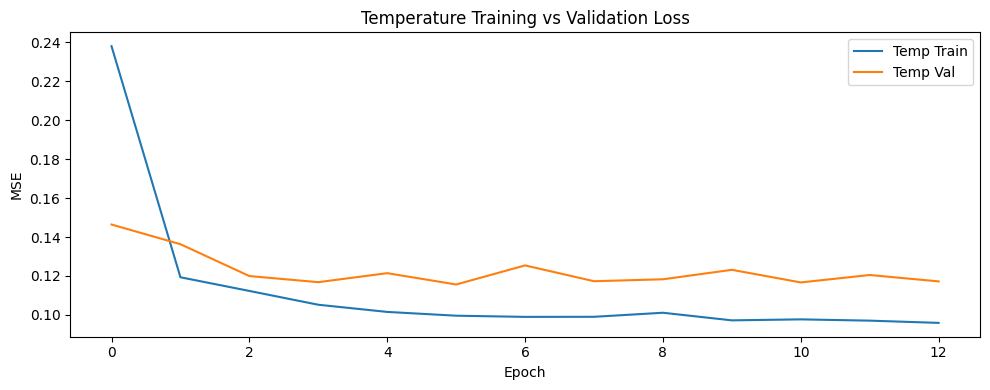

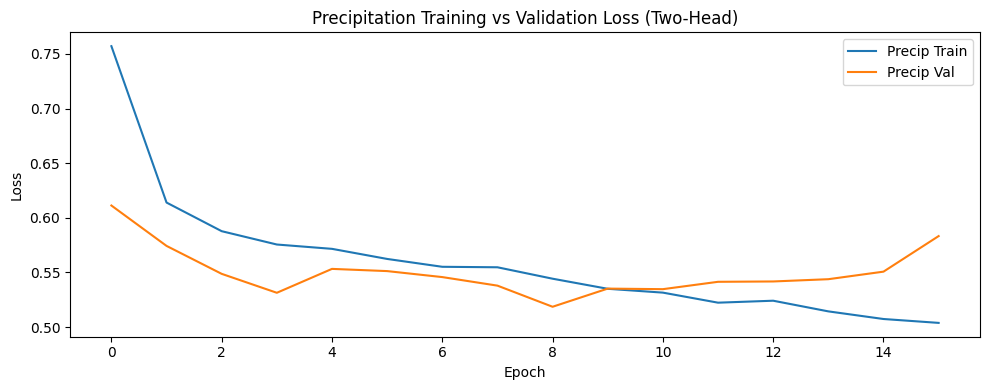

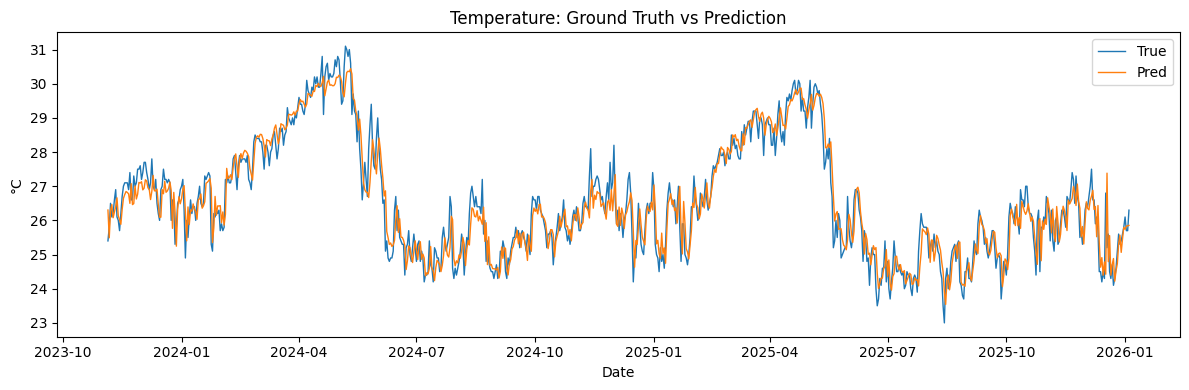

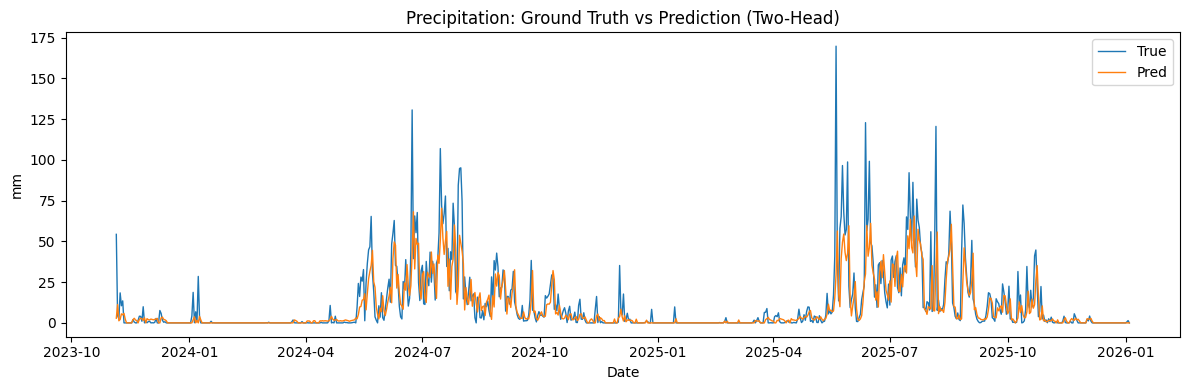

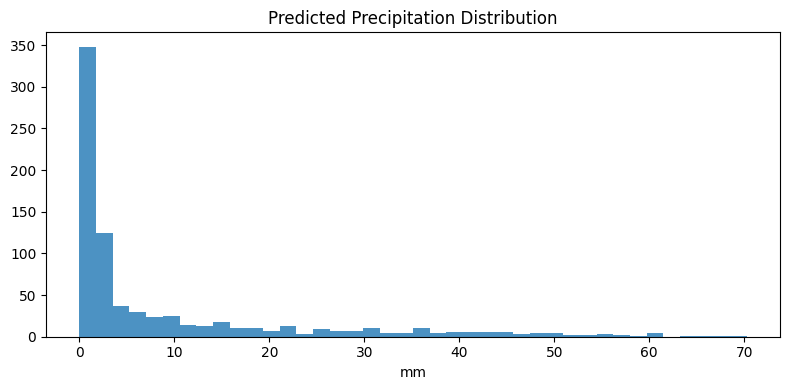

In [5]:
train_df, val_df, test_df = split_by_time(model_df)

TIME_FEATURES = ["sin_day_of_year", "cos_day_of_year"]
MULTI_FEATURES = [
    TEMP_COL,
    PRECIP_COL,
    "relative_humidity (%)",
    PRESSURE_COL,
    WIND_COL,
] + TIME_FEATURES


def run_experiment(target_name, target_col, log_target=False):
    results = {}

    for feature_set in ["univariate", "multivariate"]:
        if feature_set == "univariate":
            feature_cols = [target_col] + TIME_FEATURES
        else:
            feature_cols = MULTI_FEATURES

        (X_train, y_train, X_val, y_val, X_test, y_test), _, y_scaler = prepare_data(
            train_df,
            val_df,
            test_df,
            feature_cols,
            target_col,
            LOOKBACK,
            log_target=log_target,
        )

        train_loader = DataLoader(
            TensorDataset(torch.tensor(X_train), torch.tensor(y_train)),
            batch_size=BATCH_SIZE,
            shuffle=True,
        )
        val_loader = DataLoader(
            TensorDataset(torch.tensor(X_val), torch.tensor(y_val)),
            batch_size=BATCH_SIZE,
            shuffle=False,
        )
        test_loader = DataLoader(
            TensorDataset(torch.tensor(X_test), torch.tensor(y_test)),
            batch_size=BATCH_SIZE,
            shuffle=False,
        )

        model = GRUForecast(input_size=X_train.shape[2]).to(DEVICE)
        history = train_model(model, train_loader, val_loader)

        y_pred_scaled = predict(model, test_loader)
        y_true_scaled = y_test

        y_pred = invert_target(y_pred_scaled, y_scaler, log_target)
        y_true = invert_target(y_true_scaled, y_scaler, log_target)

        if log_target:
            y_pred = np.clip(y_pred, 0, None)

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        results[feature_set] = {
            "history": history,
            "y_true": y_true,
            "y_pred": y_pred,
            "mae": mae,
            "rmse": rmse,
        }

    baseline_true, baseline_pred = persistence_baseline(
        test_df[target_col].to_numpy(dtype=np.float32), LOOKBACK
    )
    baseline_mae = mean_absolute_error(baseline_true, baseline_pred)
    baseline_rmse = np.sqrt(mean_squared_error(baseline_true, baseline_pred))

    print(f"{target_name} baseline MAE: {baseline_mae:.4f} | RMSE: {baseline_rmse:.4f}")
    for k, v in results.items():
        print(f"{target_name} {k} MAE: {v['mae']:.4f} | RMSE: {v['rmse']:.4f}")

    return results, (baseline_mae, baseline_rmse)


# Temperature pipeline (unchanged)
temp_results, temp_baseline = run_experiment("Temperature", TEMP_COL, log_target=False)

# Precipitation two-head GRU
precip_df = build_precip_features(model_df)
precip_train_df, precip_val_df, precip_test_df = split_by_time(precip_df)

PRECIP_EXTRA = ["rain_yesterday", "rain_days_last7", "precip_sum_last7"]


def tune_threshold(y_true, rain_logits):
    probs = 1 / (1 + np.exp(-rain_logits))
    thresholds = np.linspace(0.1, 0.9, 17)
    best = {"thr": 0.5, "f1": -1.0, "precision": 0.0, "recall": 0.0}
    for thr in thresholds:
        preds = (probs >= thr).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, preds, average="binary", zero_division=0
        )
        if f1 > best["f1"]:
            best = {"thr": float(thr), "f1": float(f1), "precision": float(precision), "recall": float(recall)}
    return best


def run_precip_experiment(feature_set, lambda_amount=1.0):
    if feature_set == "univariate":
        feature_cols = [PRECIP_COL] + TIME_FEATURES
    else:
        feature_cols = [
            TEMP_COL,
            PRECIP_COL,
            "relative_humidity (%)",
            PRESSURE_COL,
            WIND_COL,
        ] + TIME_FEATURES + PRECIP_EXTRA

    (
        X_train,
        y_rain_train,
        y_amount_train,
        X_val,
        y_rain_val,
        y_amount_val,
        X_test,
        y_rain_test,
        y_amount_test,
    ), _, amount_scaler = prepare_precip_data(
        precip_train_df,
        precip_val_df,
        precip_test_df,
        feature_cols,
        LOOKBACK,
    )

    train_loader = DataLoader(
        TensorDataset(
            torch.tensor(X_train),
            torch.tensor(y_rain_train),
            torch.tensor(y_amount_train),
        ),
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
    val_loader = DataLoader(
        TensorDataset(
            torch.tensor(X_val),
            torch.tensor(y_rain_val),
            torch.tensor(y_amount_val),
        ),
        batch_size=BATCH_SIZE,
        shuffle=False,
    )
    test_loader = DataLoader(
        TensorDataset(
            torch.tensor(X_test),
            torch.tensor(y_rain_test),
            torch.tensor(y_amount_test),
        ),
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    model = GRUTwoHead(input_size=X_train.shape[2]).to(DEVICE)
    history = train_precip_model(model, train_loader, val_loader, lambda_amount=lambda_amount)

    val_logits, val_amount = predict_precip(model, val_loader)
    threshold_info = tune_threshold(y_rain_val, val_logits)
    thr = threshold_info["thr"]

    test_logits, test_amount = predict_precip(model, test_loader)
    test_probs = 1 / (1 + np.exp(-test_logits))
    test_rain_pred = (test_probs >= thr).astype(int)

    amount_mm = invert_amount(test_amount, amount_scaler)
    amount_mm = np.clip(amount_mm, 0, None)
    test_pred_mm = np.where(test_rain_pred == 1, amount_mm, 0.0)
    test_true_mm = precip_test_df[PRECIP_COL].to_numpy(dtype=np.float32)[LOOKBACK:]

    mae = mean_absolute_error(test_true_mm, test_pred_mm)
    rmse = np.sqrt(mean_squared_error(test_true_mm, test_pred_mm))

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_rain_test, test_rain_pred, average="binary", zero_division=0
    )

    return {
        "history": history,
        "threshold": threshold_info,
        "y_true": test_true_mm,
        "y_pred": test_pred_mm,
        "mae": mae,
        "rmse": rmse,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


precip_uni = run_precip_experiment("univariate", lambda_amount=1.0)
precip_multi = run_precip_experiment("multivariate", lambda_amount=1.0)

# Baseline and old GRU references
baseline_mae, baseline_rmse = 6.9292, 15.5510
old_uni_mae, old_uni_rmse = 6.4037, 14.4429
old_multi_mae, old_multi_rmse = 6.6360, 14.8711

print(f"Precipitation baseline MAE: {baseline_mae:.4f} | RMSE: {baseline_rmse:.4f}")
print(f"Old GRU univariate MAE: {old_uni_mae:.4f} | RMSE: {old_uni_rmse:.4f}")
print(f"Old GRU multivariate MAE: {old_multi_mae:.4f} | RMSE: {old_multi_rmse:.4f}")
print(
    f"Two-head GRU univariate MAE: {precip_uni['mae']:.4f} | RMSE: {precip_uni['rmse']:.4f} | "
    f"F1: {precip_uni['f1']:.4f} | thr: {precip_uni['threshold']['thr']:.2f}"
)
print(
    f"Two-head GRU multivariate MAE: {precip_multi['mae']:.4f} | RMSE: {precip_multi['rmse']:.4f} | "
    f"F1: {precip_multi['f1']:.4f} | thr: {precip_multi['threshold']['thr']:.2f}"
)

# Plot training vs validation loss
plt.figure(figsize=(10, 4))
plt.plot(temp_results["multivariate"]["history"]["train"], label="Temp Train")
plt.plot(temp_results["multivariate"]["history"]["val"], label="Temp Val")
plt.title("Temperature Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(precip_multi["history"]["train"], label="Precip Train")
plt.plot(precip_multi["history"]["val"], label="Precip Val")
plt.title("Precipitation Training vs Validation Loss (Two-Head)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Ground truth vs predictions

test_time = test_df["time"].iloc[LOOKBACK:].reset_index(drop=True)

plt.figure(figsize=(12, 4))
plt.plot(test_time, temp_results["multivariate"]["y_true"], label="True", linewidth=1)
plt.plot(test_time, temp_results["multivariate"]["y_pred"], label="Pred", linewidth=1)
plt.title("Temperature: Ground Truth vs Prediction")
plt.xlabel("Date")
plt.ylabel("°C")
plt.legend()
plt.tight_layout()
plt.show()

precip_time = precip_test_df["time"].iloc[LOOKBACK:].reset_index(drop=True)

plt.figure(figsize=(12, 4))
plt.plot(precip_time, precip_multi["y_true"], label="True", linewidth=1)
plt.plot(precip_time, precip_multi["y_pred"], label="Pred", linewidth=1)
plt.title("Precipitation: Ground Truth vs Prediction (Two-Head)")
plt.xlabel("Date")
plt.ylabel("mm")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(precip_multi["y_pred"], bins=40, alpha=0.8)
plt.title("Predicted Precipitation Distribution")
plt.xlabel("mm")
plt.tight_layout()
plt.show()